## Hexapod Kinematics Sim Interactive ##

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output
import numpy as np
import cv2
import copy
from numpy import cos, sin, pi, exp
from math import fabs, sqrt
import time
import random

In [2]:
import Hexapod_Functions
from Hexapod_Functions import Rotation_XYZ, Hexapod_Constructive_Vectors, Hexapod_System 
from Hexapod_Functions import Hexapod_Jacobian_System, Initial_Guess, Newton

In [3]:
def Vec_to_Quiver(Origin, Vector):
    
    # This function will prepare a (X,Y,Z) array vector coordinates to quiver format (X,Y,Z,U,V,W)
    # considering the determined origin coordinates.
    
    Vector_for_Quiver = np.array([Origin[0], Origin[1], Origin[2], Vector[0], Vector[1], Vector[2]])
    
    return Vector_for_Quiver

def Mov_Vector_Between(Origin_1, Origin_2, Vec_1, Vec_2):
    
    # This function is used to get the needed array to plot the movement of a vector using "quiver" with 3D matplotlib
    # In order to plot a moving vector between two moving vectors
    # Vec Format = np.array((X,Y,Z))
    
    # Origin_1 = The array with the XYZ coordinates of the first vector Origin
    # Origin_2 = The array with the XYZ coordinates of the second vector Origin
    # Vec_1 = Calculated Vector 1
    # Vec_1 = Calculated Vector 2
    
    # Vector Movimentation Aux:
    t1 = Origin_1[0] + Vec_1[0]
    t2 = Origin_1[1] + Vec_1[1]
    t3 = Origin_1[2] + Vec_1[2]
    
    d1 = (Origin_2[0] + Vec_2[0]) - (Origin_1[0] + Vec_1[0])
    d2 = (Origin_2[1] + Vec_2[1]) - (Origin_1[1] + Vec_1[1])
    d3 = (Origin_2[2] + Vec_2[2]) - (Origin_1[2] + Vec_1[2])
    
    Vector_Between_for_Quiver = np.array([(t1),(t2),(t3),(d1),(d2),(d3)])

    return Vector_Between_for_Quiver

In [4]:
# Set Constructive Properties for Animation:

a, b = Hexapod_Constructive_Vectors()

# Let's Offset Hexapod to (100,100,0):
a1 = a[0] + np.array((100,100,0)); a2 = a[1] + np.array((100,100,0)); a3 = a[2] + np.array((100,100,0))
a4 = a[3] + np.array((100,100,0)); a5 = a[4] + np.array((100,100,0)); a6 = a[5] + np.array((100,100,0))

b1 = b[0]; b2 = b[1]; b3 = b[2] 
b4 = b[3]; b5 = b[4]; b6 = b[5]

# ==========================================================================================================
# Base Static vectors for Quiver:
a1_a2 = a2 - a1
a2_a3 = a3 - a2
a3_a4 = a4 - a3
a4_a5 = a5 - a4
a5_a6 = a6 - a5
a6_a1 = a1 - a6

# Get Quiver format:
Xbase1, Ybase1, Zbase1, Ubase1, Vbase1, Wbase1 = np.array([a1[0], a1[1], a1[2], a1_a2[0], a1_a2[1], a1_a2[2]])
Xbase2, Ybase2, Zbase2, Ubase2, Vbase2, Wbase2 = np.array([a2[0], a2[1], a2[2], a2_a3[0], a2_a3[1], a2_a3[2]])
Xbase3, Ybase3, Zbase3, Ubase3, Vbase3, Wbase3 = np.array([a3[0], a3[1], a3[2], a3_a4[0], a3_a4[1], a3_a4[2]])
Xbase4, Ybase4, Zbase4, Ubase4, Vbase4, Wbase4 = np.array([a4[0], a4[1], a4[2], a4_a5[0], a4_a5[1], a4_a5[2]])
Xbase5, Ybase5, Zbase5, Ubase5, Vbase5, Wbase5 = np.array([a5[0], a5[1], a5[2], a5_a6[0], a5_a6[1], a5_a6[2]])
Xbase6, Ybase6, Zbase6, Ubase6, Vbase6, Wbase6 = np.array([a6[0], a6[1], a6[2], a6_a1[0], a6_a1[1], a6_a1[2]])

# Platform Coordinate System Vectors:
plat_x_axis = ((30, 0, 0))
plat_y_axis = ((0, 30, 0))
plat_z_axis = ((0, 0, 30))

In [5]:
def Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames):
    
    # Animation Plot Loop Function:
    # FIRST_ANI -> First animation loop since program is run.
    # position -> (x,y,z,rx,ry,rz) currently coordinates.
    # target -> (x,y,z,rx,ry,rz) target coordinates.
    # Step_size -> size of move increment for each loop .
    # n_frames -> number of frames each loop will have.
    
    P = ((100, 100, 108))
    thetaRX = 0
    thetaRY = 0
    thetaRZ = 0
        
    if (FIRST_ANI == 0):      
        P = (position[0], position[1], position[2])
        thetaRX = position[3]
        thetaRY = position[4]
        thetaRZ = position[5]
        
    P_target = (target[0], target[1], target[2])
    thetaRX_target = target[3]
    thetaRY_target = target[4]
    thetaRZ_target = target[5]    
    
    # ==========================================================================================================
    # ==========================================================================================================
    # ====================================== ~Animation Loop~ ==================================================

    # Graph Properties:
    fig = plt.figure(figsize=(12,8), facecolor='k')
    ax = fig.add_subplot(111, projection='3d')

    Xmin, Xmax = 0, 200
    Ymin, Ymax = 0, 200
    Zmin, Zmax = 0, 150

    # Number of Frames of the movement:
    frames = n_frames
    frame_time = 0.0001 #s

    # Animation Loop:
    for k in range(frames):

        # Axis Properties ======================================================================================
        # These needed to be inside the loop because the figure is cleanned every iteration

        ax.set_xlabel('\n X ', fontsize=15)
        ax.set_ylabel('\n Y ', fontsize=15)
        ax.set_zlabel('\n Z ', fontsize=15)

        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_yticks([0, 50, 100, 150, 200])
        ax.set_zticks([0, 50, 100, 150])
        ax.dist = 12

        ax.set_xlim([Xmin, Xmax])
        ax.set_ylim([Ymin, Ymax])
        ax.set_zlim([Zmin, Zmax])

        ax.quiver(Xmin, 0, 0, Xmax, 0, 0, arrow_length_ratio = 0.05, color='k')
        ax.quiver(0, Ymin, 0, 0, Ymax, 0, arrow_length_ratio = 0.05, color='k')
        ax.quiver(0, 0, Zmin, 0, 0, Zmax, arrow_length_ratio = 0.05, color='k')

        #=======================================================================================================
        #=======================================================================================================

        #  Calculate Currently Values for P(X,Y,Z) and thetaRX, thetaRY, thetaRZ:
        P_cur = ((k*(P_target[0]-P[0])/frames + P[0]), (k*(P_target[1]-P[1])/frames + P[1]), (k*(P_target[2]-P[2])/frames + P[2]))
        thetaRX_cur = k*(thetaRX_target - thetaRX)/frames + thetaRX
        thetaRY_cur = k*(thetaRY_target - thetaRY)/frames + thetaRY
        thetaRZ_cur = k*(thetaRZ_target - thetaRZ)/frames + thetaRZ

        if (k==(frames-1)):
            P_cur = P_target
            thetaRX_cur = thetaRX_target
            thetaRY_cur = thetaRY_target
            thetaRZ_cur = thetaRZ_target

        #=======================================================================================================
        # INVERSE KINEMATICS:
        # Vectorial Equation to Calculate Target Leg Vector S:
        S1_cur = P_cur + Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(b1) - a1
        S2_cur = P_cur + Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(b2) - a2
        S3_cur = P_cur + Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(b3) - a3
        S4_cur = P_cur + Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(b4) - a4
        S5_cur = P_cur + Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(b5) - a5
        S6_cur = P_cur + Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(b6) - a6

        # Currently Target Position Vectors for Legs ready for Quiver:
        XS1, YS1, ZS1, US1, VS1, WS1 = Vec_to_Quiver(a1, S1_cur)
        XS2, YS2, ZS2, US2, VS2, WS2 = Vec_to_Quiver(a2, S2_cur)
        XS3, YS3, ZS3, US3, VS3, WS3 = Vec_to_Quiver(a3, S3_cur)
        XS4, YS4, ZS4, US4, VS4, WS4 = Vec_to_Quiver(a4, S4_cur)
        XS5, YS5, ZS5, US5, VS5, WS5 = Vec_to_Quiver(a5, S5_cur)
        XS6, YS6, ZS6, US6, VS6, WS6 = Vec_to_Quiver(a6, S6_cur)

        ax.quiver(XS1, YS1, ZS1, US1, VS1, WS1, arrow_length_ratio = 0.06, color='r')
        ax.quiver(XS2, YS2, ZS2, US2, VS2, WS2, arrow_length_ratio = 0.06, color='r')
        ax.quiver(XS3, YS3, ZS3, US3, VS3, WS3, arrow_length_ratio = 0.06, color='r')
        ax.quiver(XS4, YS4, ZS4, US4, VS4, WS4, arrow_length_ratio = 0.06, color='r')
        ax.quiver(XS5, YS5, ZS5, US5, VS5, WS5, arrow_length_ratio = 0.06, color='r')
        ax.quiver(XS6, YS6, ZS6, US6, VS6, WS6, arrow_length_ratio = 0.06, color='r')

        # Ground Base Fixed Vectors =============================================================================  
        ax.quiver(Xbase1, Ybase1, Zbase1, Ubase1, Vbase1, Wbase1, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xbase2, Ybase2, Zbase2, Ubase2, Vbase2, Wbase2, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xbase3, Ybase3, Zbase3, Ubase3, Vbase3, Wbase3, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xbase4, Ybase4, Zbase4, Ubase4, Vbase4, Wbase4, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xbase5, Ybase5, Zbase5, Ubase5, Vbase5, Wbase5, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xbase6, Ybase6, Zbase6, Ubase6, Vbase6, Wbase6, arrow_length_ratio = 0.01, color='b')

        # Currently Platform Base Vectors =======================================================================
        Xplat1, Yplat1, Zplat1, Uplat1, Vplat1, Wplat1 = Mov_Vector_Between(a1, a2, S1_cur, S2_cur)
        Xplat2, Yplat2, Zplat2, Uplat2, Vplat2, Wplat2 = Mov_Vector_Between(a2, a3, S2_cur, S3_cur)
        Xplat3, Yplat3, Zplat3, Uplat3, Vplat3, Wplat3 = Mov_Vector_Between(a3, a4, S3_cur, S4_cur)
        Xplat4, Yplat4, Zplat4, Uplat4, Vplat4, Wplat4 = Mov_Vector_Between(a4, a5, S4_cur, S5_cur)
        Xplat5, Yplat5, Zplat5, Uplat5, Vplat5, Wplat5 = Mov_Vector_Between(a5, a6, S5_cur, S6_cur)
        Xplat6, Yplat6, Zplat6, Uplat6, Vplat6, Wplat6 = Mov_Vector_Between(a6, a1, S6_cur, S1_cur)

        ax.quiver(Xplat1, Yplat1, Zplat1, Uplat1, Vplat1, Wplat1, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xplat2, Yplat2, Zplat2, Uplat2, Vplat2, Wplat2, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xplat3, Yplat3, Zplat3, Uplat3, Vplat3, Wplat3, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xplat4, Yplat4, Zplat4, Uplat4, Vplat4, Wplat4, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xplat5, Yplat5, Zplat5, Uplat5, Vplat5, Wplat5, arrow_length_ratio = 0.01, color='b')
        ax.quiver(Xplat6, Yplat6, Zplat6, Uplat6, Vplat6, Wplat6, arrow_length_ratio = 0.01, color='b')

        # =========================================================================================================
        # =========================================================================================================
        # Plot Platform Axis Movement

        plat_x_axis_cur = Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(plat_x_axis)
        plat_y_axis_cur = Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(plat_y_axis)
        plat_z_axis_cur = Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(plat_z_axis)

        Xplatx, Yplatx, Zplatx, Uplatx, Vplatx, Wplatx = Vec_to_Quiver(P_cur, plat_x_axis_cur)
        Xplaty, Yplaty, Zplaty, Uplaty, Vplaty, Wplaty = Vec_to_Quiver(P_cur, plat_y_axis_cur)
        Xplatz, Yplatz, Zplatz, Uplatz, Vplatz, Wplatz = Vec_to_Quiver(P_cur, plat_z_axis_cur)

        ax.quiver(Xplatx, Yplatx, Zplatx, Uplatx, Vplatx, Wplatx, arrow_length_ratio = 0.2, color='k')
        ax.quiver(Xplaty, Yplaty, Zplaty, Uplaty, Vplaty, Wplaty, arrow_length_ratio = 0.2, color='k')
        ax.quiver(Xplatz, Yplatz, Zplatz, Uplatz, Vplatz, Wplatz, arrow_length_ratio = 0.2, color='k')

        # Platform Axis Text:
        zdir = (0,0,0)

        (x_x, x_y, x_z) = P_cur + Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(plat_x_axis)
        (y_x, y_y, y_z) = P_cur + Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(plat_y_axis)
        (z_x, z_y, z_z) = P_cur + Rotation_XYZ(thetaRX_cur, thetaRY_cur, thetaRZ_cur).dot(plat_z_axis)

        ax.text(x_x, x_y, x_z, 'x`', zdir)
        ax.text(y_x, y_y, y_z, 'y`', zdir)
        ax.text(z_x, z_y, z_z, 'z`', zdir)

        # Legs Number Text:
        ax.text(a1[0], a1[1], a1[2], ' L1', zdir)
        ax.text(a2[0], a2[1], a2[2], ' L2', zdir)
        ax.text(a3[0], a3[1], a3[2], ' L3', zdir)
        ax.text(a4[0], a4[1], a4[2], ' L4', zdir)
        ax.text(a5[0], a5[1], a5[2], ' L5', zdir)
        ax.text(a6[0], a6[1], a6[2], ' L6', zdir)

        # Output State to be used as pos feedback:
        P_out = P_cur
        thetaRX_out = thetaRX_cur
        thetaRY_out = thetaRY_cur
        thetaRZ_out = thetaRZ_cur
        
        output = np.array((P_out[0], P_out[1], P_out[2], thetaRX_out, thetaRY_out, thetaRZ_out))

        FIRST_ANI = 0
        
        Leg1 = np.linalg.norm(S1_cur)
        Leg2 = np.linalg.norm(S2_cur)
        Leg3 = np.linalg.norm(S3_cur)
        Leg4 = np.linalg.norm(S4_cur)
        Leg5 = np.linalg.norm(S5_cur)
        Leg6 = np.linalg.norm(S6_cur)

        # Display Figure (GAMBIARRA) =======================================================================
        fig.canvas.draw()
        img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        img2 = copy.deepcopy(img)
        img2[np.where((img2 >= [0,0,0]).all(axis = 2))] = [0,0,0]
        img = np.hstack((img, img2))
        
        cv2.putText(img, "Inverse Kinematics Calculations:", (905, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(img, "Leg 1 length: {} units".format(Leg1), (905, 50),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Leg 2 length: {} units".format(Leg2), (905, 70),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Leg 3 length: {} units".format(Leg3), (905, 90),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Leg 4 length: {} units".format(Leg4), (905, 110),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Leg 5 length: {} units".format(Leg5), (905, 130),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Leg 6 length: {} units".format(Leg6), (905, 150),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        cv2.putText(img, "Actual Positions (each step: {:.2f}):".format(Step_size), (905, 200),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(img, "X pos: {} units".format(P_cur[0]), (905, 220),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Y pos: {} units".format(P_cur[1]), (905, 240),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Z pos: {} units".format(P_cur[2]), (905, 260),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "RX: {} degrees".format(thetaRX_cur), (905, 280),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "RY: {} degrees".format(thetaRY_cur), (905, 300),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "RZ: {} degrees".format(thetaRZ_cur), (905, 320),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        True_Values = np.array([P_out[0]-100, P_out[1]-100, P_out[2], thetaRX_out, thetaRY_out, thetaRZ_out], dtype=np.float64)
        tol = 1e-8
        Init_Guess, L = Initial_Guess(True_Values)
        Answer, n, total_time = Newton(Init_Guess, L, tol)
        max_error = np.max(np.absolute(True_Values - Answer))
        
        cv2.putText(img, "Forward Kinematics Method Results (tol = {}):".format(tol), (905, 400),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        cv2.putText(img, "X calc: {} units".format(Answer[0]+100), (905, 420),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Y calc: {} units".format(Answer[1]+100), (905, 440),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Z calc: {} units".format(Answer[2]), (905, 460),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "RX calc: {} degrees".format(Answer[3]), (905, 480),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "RY calc: {} degrees".format(Answer[4]), (905, 500),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "RZ calc: {} degrees".format(Answer[5]), (905, 520),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        cv2.putText(img, "Max Error: {}".format(max_error), (905, 540),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        cv2.putText(img, "Hexapod Kinematics Interactive Simulator", (113, 50),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.rectangle(img, (108, 70), (778, 502), (255, 0, 0), 2)
        cv2.imshow("Hexapod Kinematics Interactive Sim",img)
        clear_output(wait = True)
        cv2.waitKey(1)
        
        plt.pause(frame_time)
        ax.cla()

    return output, FIRST_ANI, img

In [ ]:
# Hexapod Keyboard Controller Tool:

# Starting Position:
FIRST_ANI = 1 # Start first animatiom flag = True
position = np.array((100,100,108,0,0,0))
target = np.array((100,100,108,0,0,0))

# Movement Step increment size and animation number of frames
Step_size = 5
n_frames = 5

# Show starting position frame:
position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)

while True:
    
    ###################################################################################################
    # Keyboard Configuration:
    
    key = cv2.waitKey(1) or 0xff    
    
    # Change Step Size:
    
    if key == ord(' '): # Step+
        
        position, FIRST_ANI, img = Hexapod_Anim(1, np.array((100,100,108,0,0,0)), np.array((100,100,108,0,0,0)), 5, 1) 
    
    if key == ord('7'): # Step+
    
        Step_size += 0.01
        
        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, 1)
        
    if key == ord('8'): # Step-
    
        Step_size -= 0.01
        
        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, 1)
        
    if key == ord('4'): # Step+
    
        Step_size += 0.1
        
        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, 1)
        
    if key == ord('5'): # Step-
    
        Step_size -= 0.1
        
        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, 1)
        
        
    if key == ord('1'): # Step+
    
        Step_size += 1
        
        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, 1)
        
    if key == ord('2'): # Step-
    
        Step_size -= 1
        
        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, 1)
    
    ###################################################################################################
    if key == ord('d'): # X+
     
        target = position + np.array((Step_size,0,0,0,0,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)

    if key == ord('a'): # X-
        
        target = position + np.array((-Step_size,0,0,0,0,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
              
    if key == ord('w'): # Y+
        
        target = position + np.array((0,Step_size,0,0,0,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
            
    if key == ord('s'): # Y-
        
        target = position + np.array((0,-Step_size,0,0,0,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
        
    ###################################################################
        
    if key == ord('t'): # Z+
        
        target = position + np.array((0,0,Step_size,0,0,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
        
    if key == ord('g'): # Z-
        
        target = position + np.array((0,0,-Step_size,0,0,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
        
    ###################################################################
    
    if key == ord('l'): # RX+
     
        target = position + np.array((0,0,0,Step_size,0,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)

    if key == ord('j'): # RX-
        
        target = position + np.array((0,0,0,-Step_size,0,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
              
    if key == ord('i'): # RY+
        
        target = position + np.array((0,0,0,0,Step_size,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
            
    if key == ord('k'): # RY-
        
        target = position + np.array((0,0,0,0,-Step_size,0))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
        
    ###################################################################
    
    if key == ord('p'): # RZ+
        
        target = position + np.array((0,0,0,0,0,Step_size))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
        
    if key == ord('ç'): # RZ-
        
        target = position + np.array((0,0,0,0,0,-Step_size))

        position, FIRST_ANI, img = Hexapod_Anim(FIRST_ANI, position, target, Step_size, n_frames)
               
    # Press K to Close Game:
    if key == ord('q'):
        break
    
    
cv2.destroyAllWindows()   

### Last Frame Example ###

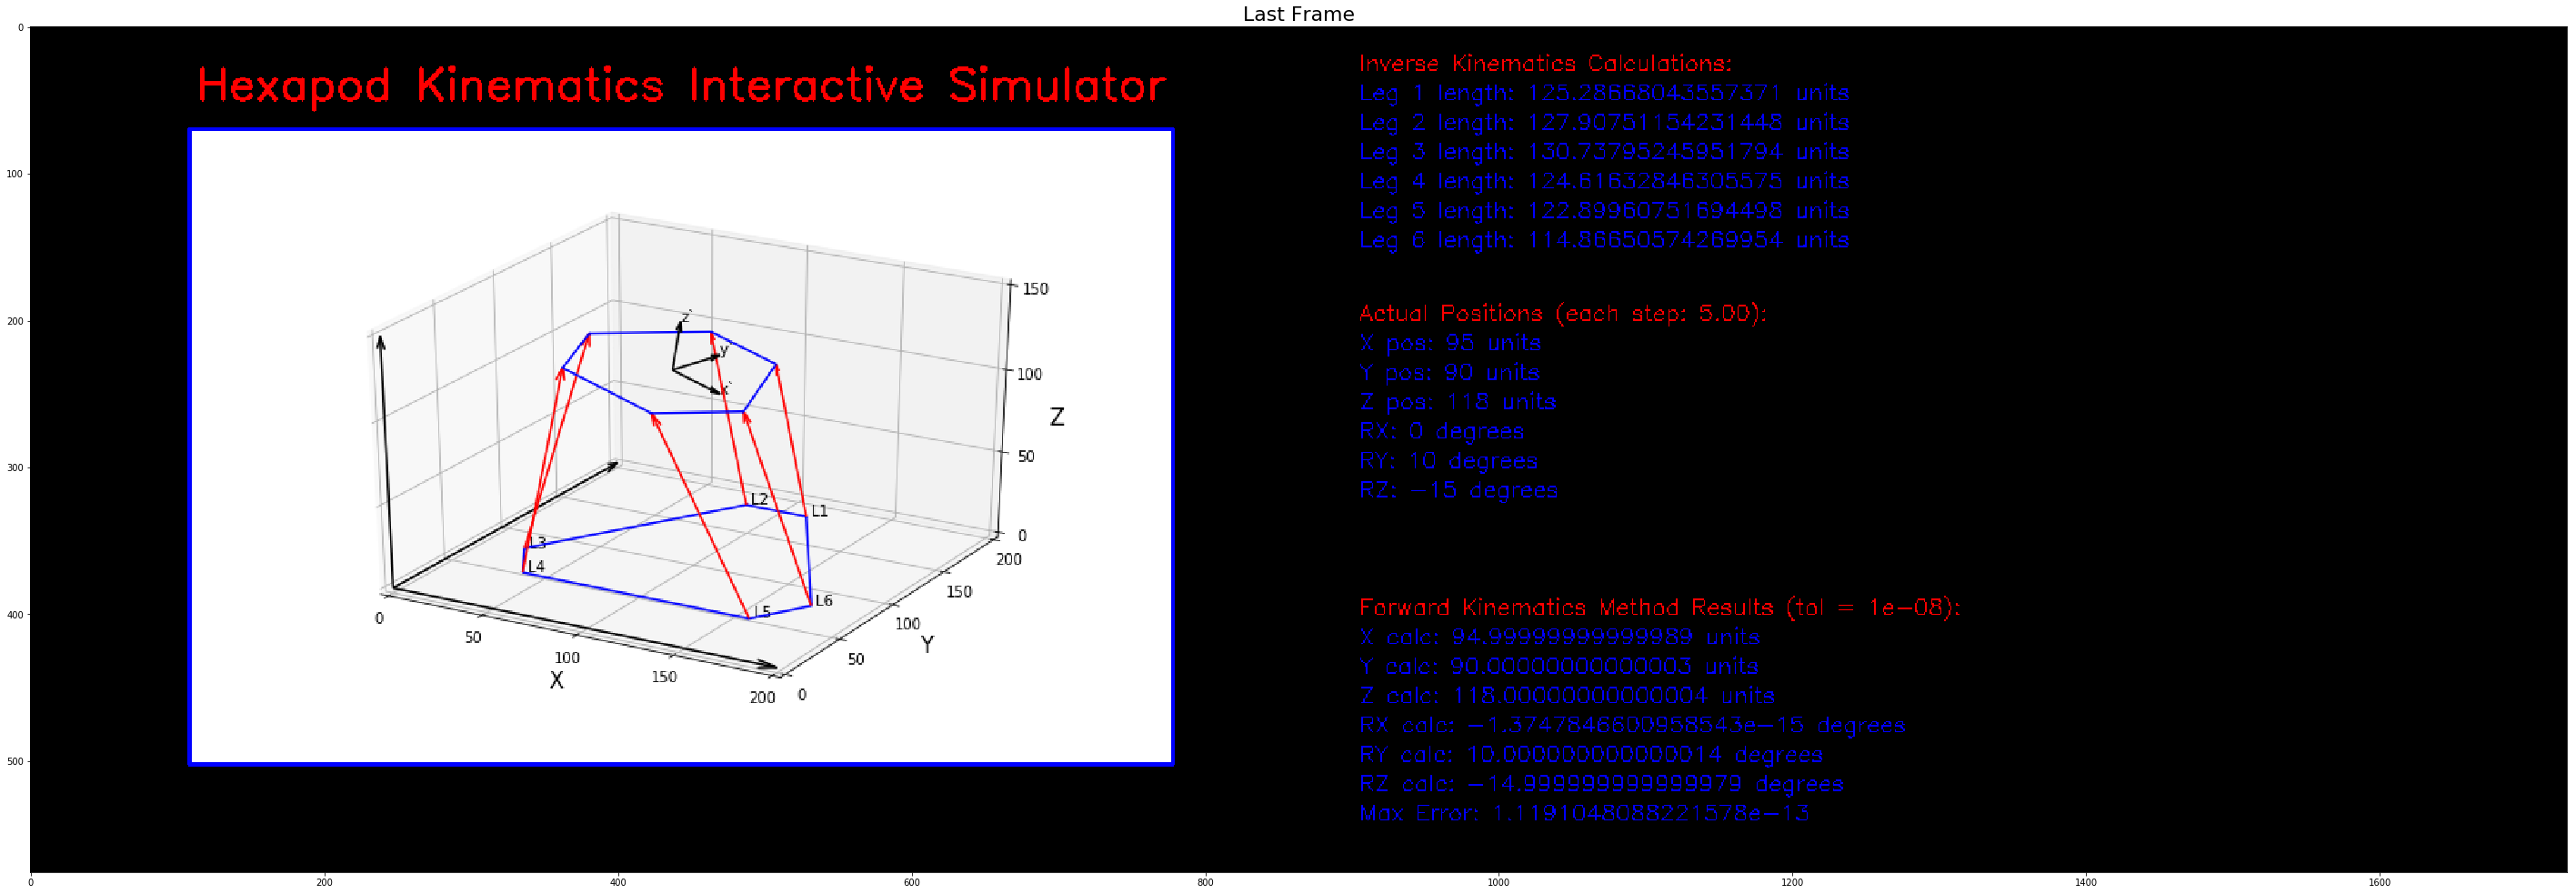

In [9]:
import sys
sys.path.append("C:/Users/Mafeus/Desktop/Git_Repos/OpenCV")
import OpCV_Utils

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
OpCV_Utils.show_single_image_plt(img_rgb, 'Last Frame', (50,60))